# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Cyborg\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 
def partition(x):
    if x < 3:
        return 0
    return 1
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

In [10]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup


In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:18<00:00, 2437.38it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [14]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

## [4.2] Bi-Grams and n-Grams.

## [4.3] TF-IDF

## [4.4] Word2Vec

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

#### [4.4.1.2] TFIDF weighted W2v

# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [15]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings("ignore")

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
X=preprocessed_reviews[:]
y=final['Score'][:]
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
bow = CountVectorizer()
X_train_bow=bow.fit_transform(X_train)
X_test_bow=bow.transform(X_test)
# print(X_train_bow.shape, y_train.shape)


depth=[1,5,10,50,100, 500,1000]
sample_split=[2,5,50,100,200 ]
parameters=dict(max_depth=depth,min_samples_split=sample_split)
clf=RandomizedSearchCV(tree.DecisionTreeClassifier(),parameters, scoring='roc_auc', refit=True, cv=3)

clf.fit(X_train_bow, y_train)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(X_train_bow)
score=roc_auc_score(y_train, pred)
split=clf.best_params_['min_samples_split']
depth=clf.best_params_['max_depth']

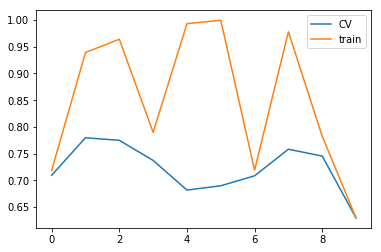

In [18]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

Best value of max_depth:  50
Best value of min_samples_split:  100
ROC SCORE ON BEST HYPER-PARAMETERS:  0.7737884200289202


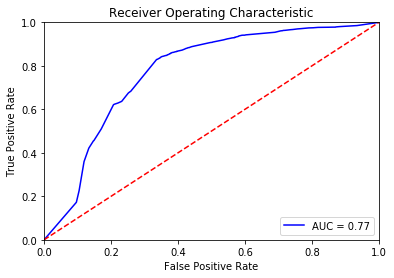

In [19]:
print('Best value of max_depth: ', depth)
print('Best value of min_samples_split: ', split)
model=tree.DecisionTreeClassifier(max_depth=depth, min_samples_split=split)
model.fit(X_train_bow, y_train)
w=model.feature_importances_

pred=model.predict_proba(X_test_bow)[:,1]
score=roc_auc_score(y_test, pred)


print('ROC SCORE ON BEST HYPER-PARAMETERS: ', score)
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [21]:
bow_features=bow.get_feature_names()
# d = dict(zip(bow_features, w))
# ss=sorted(d.items(), key= lambda t:t[1])
a=w.reshape(1,33082)
a.shape
df = pd.DataFrame(a, columns=bow_features).T


### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [22]:
# Please write all the code with proper documentation
print('top 10 features for +ve class: \n', df[0].sort_values(ascending=True)[0:10])

top 10 features for +ve class: 
 aa             0.0
polite         0.0
polishing      0.0
polished       0.0
polish         0.0
polinarious    0.0
policy         0.0
policies       0.0
police         0.0
poles          0.0
Name: 0, dtype: float64


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [23]:
print('top 10 features for -ve class: \n', df[0].sort_values(ascending=False)[:10])

top 10 features for -ve class: 
 not             0.078534
disappointed    0.040397
great           0.038602
worst           0.033301
awful           0.026089
waste           0.020970
delicious       0.020740
best            0.018485
love            0.016922
terrible        0.016883
Name: 0, dtype: float64


### [5.1.3] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [24]:
# Please write all the code with proper documentation
import graphviz
dot_data = tree.export_graphviz(model, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("tree_representation_bow")

'tree_representation_bow.pdf'

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [25]:
# Please write all the code with proper documentation
X=preprocessed_reviews[:]
y=final['Score'][:]
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
tfidf = TfidfVectorizer()
X_train_tfidf=tfidf.fit_transform(X_train)
X_test_tfidf=tfidf.transform(X_test)
# print(X_train_bow.shape, y_train.shape)


depth=[1,5,10,50,100, 500,1000]
sample_split=[2,5,50,100,200 ]
parameters=dict(max_depth=depth,min_samples_split=sample_split)
clf=RandomizedSearchCV(tree.DecisionTreeClassifier(),parameters, scoring='roc_auc', refit=True, cv=3)

clf.fit(X_train_tfidf, y_train)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(X_train_tfidf)
score=roc_auc_score(y_train, pred)
split=clf.best_params_['min_samples_split']
depth=clf.best_params_['max_depth']

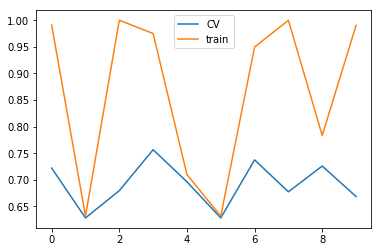

In [26]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

Best value of max_depth:  1000
Best value of min_samples_split:  200
ROC SCORE ON BEST HYPER-PARAMETERS:  0.767843123476201


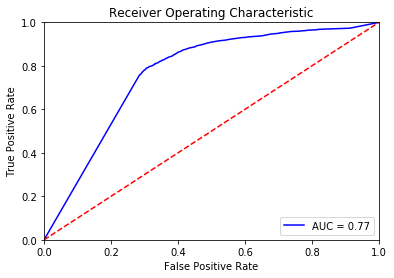

In [27]:
print('Best value of max_depth: ', depth)
print('Best value of min_samples_split: ', split)
model=tree.DecisionTreeClassifier(max_depth=depth, min_samples_split=split)
model.fit(X_train_tfidf, y_train)
w=model.feature_importances_

pred=model.predict_proba(X_test_tfidf)[:,1]
score=roc_auc_score(y_test, pred)


print('ROC SCORE ON BEST HYPER-PARAMETERS: ', score)
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
tfidf_features=tfidf.get_feature_names()
# d = dict(zip(bow_features, w))
# ss=sorted(d.items(), key= lambda t:t[1])
a=w.reshape(1,33082)
a.shape
df = pd.DataFrame(a, columns=tfidf_features).T


### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [30]:
# Please write all the code with proper documentation
print('top 10 features for +ve class: \n', df[0].sort_values(ascending=True)[0:10])

top 10 features for +ve class: 
 aa          0.0
plunged     0.0
plunge      0.0
plums       0.0
plumpthe    0.0
plumpest    0.0
plumper     0.0
plumped     0.0
plumes      0.0
plumbing    0.0
Name: 0, dtype: float64


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [31]:
# Please write all the code with proper documentation
print('top 10 features for -ve class: \n', df[0].sort_values(ascending=False)[:10])

top 10 features for -ve class: 
 not             0.075247
great           0.032727
disappointed    0.032382
worst           0.030171
awful           0.021972
waste           0.021350
horrible        0.020451
return          0.020449
delicious       0.015086
best            0.014513
Name: 0, dtype: float64


### [5.2.3] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [32]:


# Please write all the code with proper documentation
import graphviz
dot_data = tree.export_graphviz(model, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("tree_representation_tfidf")

'tree_representation_tfidf.pdf'

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [33]:
# Please write all the code with proper documentation
from gensim.models import Word2Vec
import gensim

In [34]:
list_sent=[]
for sent in preprocessed_reviews:
    list_sent.append(sent.split())
X=list_sent[:]
y=final['Score'][:]
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)

w2v_model=gensim.models.Word2Vec(X_train,min_count=5, size=50)
w2v_words = list(w2v_model.wv.vocab)
# Then vectorize your train model as
sent_vectors_train = [];
for sent in tqdm(X_train):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

# And then vectorize test as

sent_vectors_test = [];
for sent in tqdm(X_test):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent: #
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 13822/13822 [00:25<00:00, 498.53it/s]


In [35]:
depth=[1,5,10,50,100, 500,1000]
sample_split=[2,5,50,100,200 ]
parameters=dict(max_depth=depth,min_samples_split=sample_split)
clf=RandomizedSearchCV(tree.DecisionTreeClassifier(),parameters, scoring='roc_auc', refit=True, cv=3)

clf.fit(sent_vectors_train, y_train)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
# pred=clf.predict(X_train_tfidf)
# score=roc_auc_score(y_train, pred)
split=clf.best_params_['min_samples_split']
depth=clf.best_params_['max_depth']

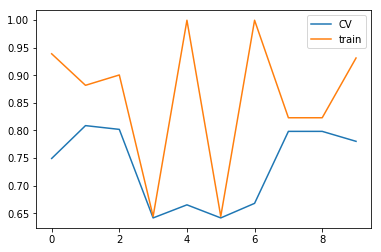

In [36]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

Best value of max_depth:  10
Best value of min_samples_split:  200
ROC SCORE ON BEST HYPER-PARAMETERS:  0.8205833125400208


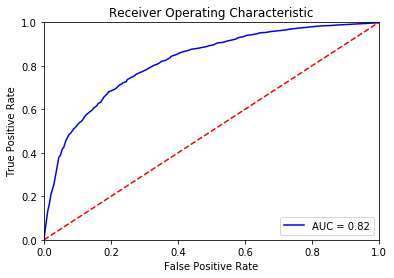

In [37]:
print('Best value of max_depth: ', depth)
print('Best value of min_samples_split: ', split)
model=tree.DecisionTreeClassifier(max_depth=depth, min_samples_split=split)
model.fit(sent_vectors_train, y_train)
w=model.feature_importances_

pred=model.predict_proba(sent_vectors_test)[:,1]
score=roc_auc_score(y_test, pred)


print('ROC SCORE ON BEST HYPER-PARAMETERS: ', score)
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## [5.3] Applying Decision Trees on TFIDF AVG W2V,<font color='red'> SET 4</font>

In [38]:
# Please write all the code with proper documentation
list_sent=[]
for sent in preprocessed_reviews:
    list_sent.append(sent.split())
X=preprocessed_reviews[:]
y=final['Score'][:]
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X,y , test_size=0.30, random_state=42)

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train_pre)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in X_train_pre:
    # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test_pre)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; 
row=0;
for sent in X_test_pre: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    

In [39]:
depth=[1,5,10,50,100, 500,1000]
sample_split=[2,5,50,100,200 ]
parameters=dict(max_depth=depth,min_samples_split=sample_split)
clf=RandomizedSearchCV(tree.DecisionTreeClassifier(),parameters, scoring='roc_auc', refit=True, cv=3)

clf.fit(tfidf_sent_vectors_train, y_train_pre)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
# pred=clf.predict(X_train_tfidf)
# score=roc_auc_score(y_train, pred)
split=clf.best_params_['min_samples_split']
depth=clf.best_params_['max_depth']

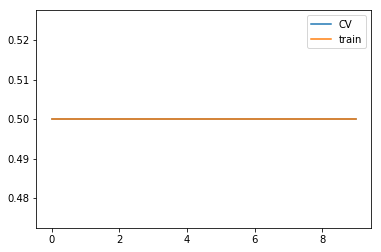

In [40]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

Best value of max_depth:  100
Best value of min_samples_split:  200
ROC SCORE ON BEST HYPER-PARAMETERS:  0.5


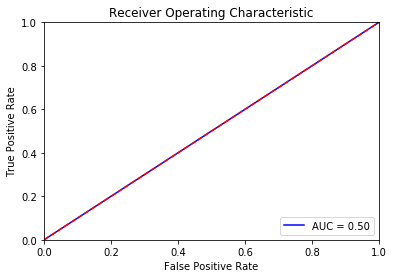

In [41]:
print('Best value of max_depth: ', depth)
print('Best value of min_samples_split: ', split)
model=tree.DecisionTreeClassifier(max_depth=depth, min_samples_split=split)
model.fit(tfidf_sent_vectors_train, y_train_pre)
w=model.feature_importances_

pred=model.predict_proba(tfidf_sent_vectors_test)[:,1]
score=roc_auc_score(y_test, pred)


print('ROC SCORE ON BEST HYPER-PARAMETERS: ', score)
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# [6] Conclusions

In [45]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "ROC_AUC_Score"]

x.add_row(["BOW" , 0.77])
# x.add_row(["BOW",  0.50])
x.add_row(["TFIDF", 0.77])
# x.add_row(["TFIDF", 0.71])
x.add_row(["Avgw2vec",  0.82])
# x.add_row(["Avgw2vec",  0.62])
x.add_row(["TFIDF-W2V",  0.50])
# x.add_row(["TFIDF-W2V",  0.])

print(x)

+------------+---------------+
| Vectorizer | ROC_AUC_Score |
+------------+---------------+
|    BOW     |      0.77     |
|   TFIDF    |      0.77     |
|  Avgw2vec  |      0.82     |
| TFIDF-W2V  |      0.5      |
+------------+---------------+
